## NOTE:
This one is plotting the results of "Analyze connectivity higher order sources". Run that notebook first.

In [3]:
import numpy
import pandas

import conntility

from scipy.spatial.distance import cdist
import tqdm

from matplotlib import pyplot as plt

In [4]:
fn_data = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_effect.h5"

df_human_pre = pandas.read_hdf(fn_data, key="human/pre")
df_human_post = pandas.read_hdf(fn_data, key="human/post")
df_rat_pre = pandas.read_hdf(fn_data, key="rat/pre")
df_rat_post = pandas.read_hdf(fn_data, key="rat/post")

Correlation coefficient between number of touches and number of touches with nearest neighbor

In [7]:
def corrcoef_from_contingency(series_in, cols_touches, col_values):
    x = series_in[cols_touches[0]].values
    y = series_in[cols_touches[1]].values
    z = series_in[col_values].values
    mn1 = (x * z).sum() / z.sum()
    mn2 = (y * z).sum() / z.sum()
    cov = ((x - mn1) * (y - mn2) * z).sum() / z.sum()

    v1 = (((x - mn1) ** 2) * z).sum() / z.sum()
    v2 = (((y - mn2) ** 2) * z).sum() / z.sum()

    return cov / numpy.sqrt(v1 * v2)

cc_human_pre = df_human_pre.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_pre"], "count")
cc_human_post = df_human_post.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_post"], "count")
cc_rat_pre = df_rat_pre.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_pre"], "count")
cc_rat_post = df_rat_post.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_post"], "count")

/nvme/reimann/2290781/ipykernel_152341/1555361404.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
/nvme/reimann/2290781/ipykernel_152341/1555361404.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
/nvme/reimann/2290781/ipykernel_152341/1555361404.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
/nvme/reimann/2290781/ipykernel_152341/1555361404.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))


Text(0.5, 0, 'Horizontal offset')

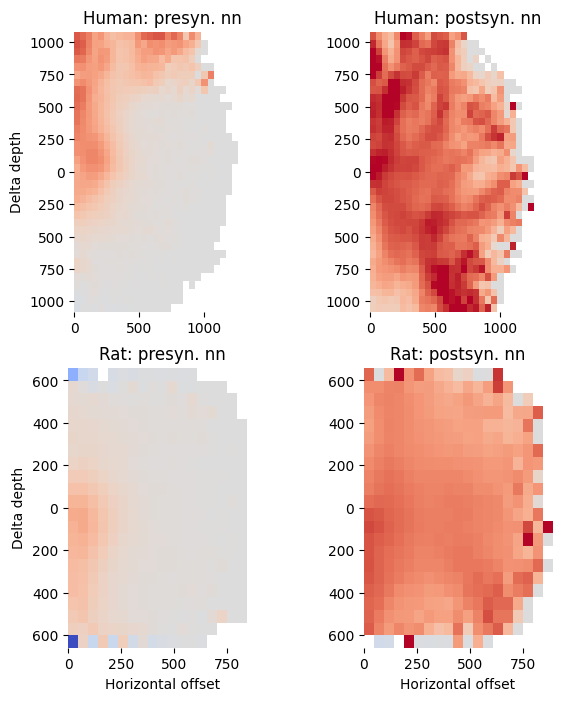

In [24]:
clim = [-0.5, 0.5]
cmap = "coolwarm"

def make_extent(df):
    delta_xz = df.columns[-1] - df.columns[-2]
    delta_y = df.index[-1] - df.index[-2]
    
    extent = [df.columns[0] - delta_xz/2, df.columns[-1] + delta_xz/2,
             df.index[-1] + delta_y/2, df.index[0] - delta_y/2]
    return extent

fig = plt.figure(figsize=(7, 8))

ax = fig.add_subplot(2, 2, 1)
img = cc_human_pre.drop(-1).sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_ylim(sorted(ax.get_ylim()))
ax.set_frame_on(False)
ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
ax.set_title("Human: presyn. nn")
ax.set_ylabel("Delta depth")

ax = fig.add_subplot(2, 2, 2)
img = cc_human_post.drop(-1).sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_frame_on(False)
ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
ax.set_title("Human: postsyn. nn")

ax = fig.add_subplot(2, 2, 3)
img = cc_rat_pre.drop(-1).sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_ylim(sorted(ax.get_ylim()))
ax.set_frame_on(False)
ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
ax.set_title("Rat: presyn. nn")
ax.set_ylabel("Delta depth")
ax.set_xlabel("Horizontal offset")

ax = fig.add_subplot(2, 2, 4)
img = cc_rat_post.drop(-1).sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_frame_on(False)
ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
ax.set_title("Rat: postsyn. nn")
ax.set_xlabel("Horizontal offset")

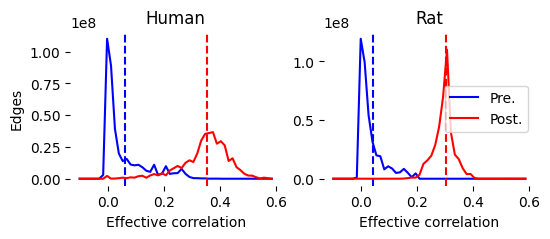

In [46]:
bins = numpy.linspace(-0.1, 0.6, 51)
fig = plt.figure(figsize=(6, 2))

ax = fig.add_subplot(1, 2, 1)
edges = df_human_pre.groupby(["xz", "y"])["count"].sum()
H = numpy.histogram(cc_human_pre.values, weights=edges.values, bins=bins)[0]
mn = edges.mul(cc_human_pre, fill_value=0).sum() / edges.sum()
ax.plot(bins[:-1], H, color="blue", label="Pre.")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="blue", ls="--")
ax.set_ylabel("Edges")
ax.set_xlabel("Effective correlation")
ax.set_title("Human")
ax.set_frame_on(False)

edges = df_human_post.groupby(["xz", "y"])["count"].sum()
H = numpy.histogram(cc_human_post.values, weights=edges.values, bins=bins)[0]
mn = edges.mul(cc_human_post, fill_value=0).sum() / edges.sum()
ax.plot(bins[:-1], H, color="red", label="Post.")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="red", ls="--")

ax = fig.add_subplot(1, 2, 2)
edges = df_rat_pre.groupby(["xz", "y"])["count"].sum()
H = numpy.histogram(cc_rat_pre.values, weights=edges.values, bins=bins)[0]
mn = edges.mul(cc_rat_pre, fill_value=0).sum() / edges.sum()
ax.plot(bins[:-1], H, color="blue", label="Pre.")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="blue", ls="--")

edges = df_rat_post.groupby(["xz", "y"])["count"].sum()
H = numpy.histogram(cc_rat_post.values, weights=edges.values, bins=bins)[0]
mn = edges.mul(cc_rat_post, fill_value=0).sum() / edges.sum()
ax.plot(bins[:-1], H, color="red", label="Post.")
ax.set_ylim(ax.get_ylim())
ax.plot([mn, mn], ax.get_ylim(), color="red", ls="--")
plt.legend()
ax.set_xlabel("Effective correlation")
ax.set_title("Rat")
ax.set_frame_on(False)

/nvme/reimann/2290781/ipykernel_152341/567487589.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
/nvme/reimann/2290781/ipykernel_152341/567487589.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
/nvme/reimann/2290781/ipykernel_152341/567487589.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
/nvme/reimann/2290781/ipykernel_152341/567487589.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
/nvme/reimann/2290781/ipykernel_152341/567487589.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
/nvme/reimann/2290781/ipykernel_152341/5

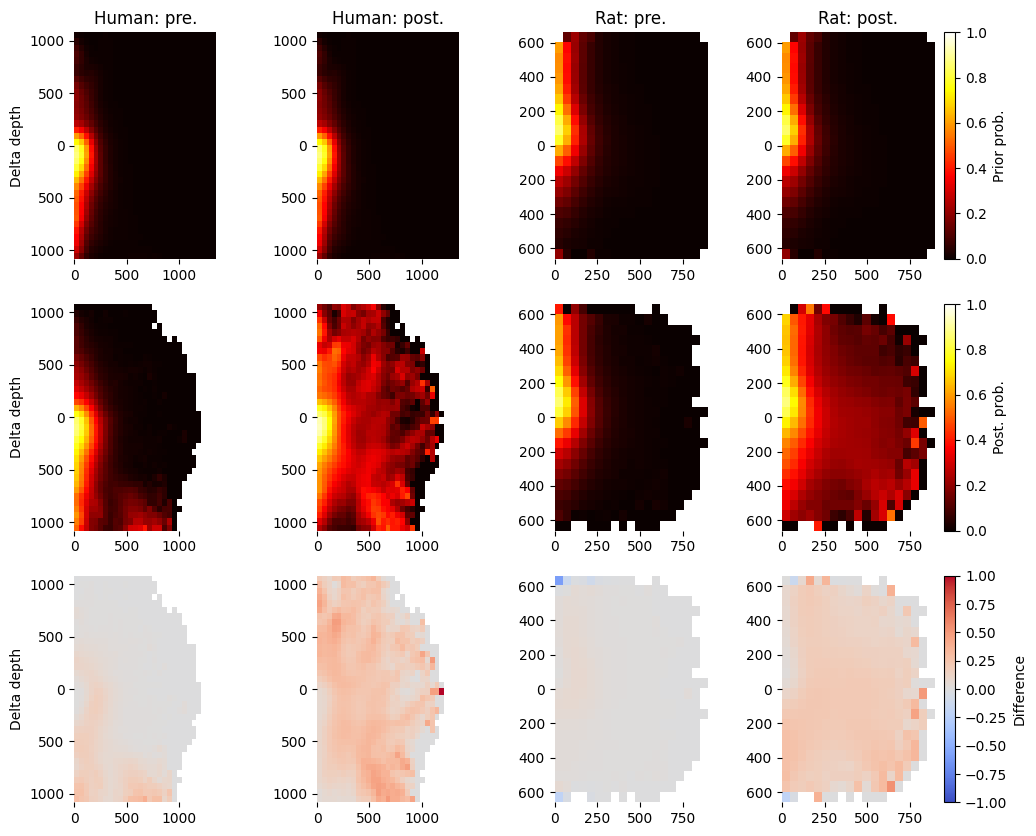

In [110]:
def p_prior_post_fun(df_in, thresh=1, col="touches_nn_post"):
    v = df_in["touches_pair"] >= thresh
    prior = df_in.loc[v]["count"].sum() / df_in["count"].sum()
    df_in = df_in.loc[v]
    v = df_in[col] >= thresh
    posterior = df_in.loc[v]["count"].sum() / df_in["count"].sum()
    return pandas.Series({
        "prior": prior,
        "posterior": posterior
    })


clim = [0.0, 1.0]
cmap = "hot"
thresh = 2

fig = plt.figure(figsize=(12, 10))
dfs = [df_human_pre, df_human_post, df_rat_pre, df_rat_post]
cols = ["touches_nn_pre", "touches_nn_post", "touches_nn_pre", "touches_nn_post"]
titles = ["Human: pre.", "Human: post.", "Rat: pre.", "Rat: post."]

for i in range(len(dfs)):
    dsrc = dfs[i]
    res = dsrc.groupby(["xz", "y"]).apply(p_prior_post_fun, thresh=thresh, col=cols[i])
    
    ax = fig.add_subplot(3, len(dfs), i + 1)
    img = res["prior"].drop(-1).sort_index().unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    ax.set_frame_on(False)
    ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
    #ax.set_title("Thresh: {0}".format(thresh))
    if i == 0:
        ax.set_ylabel("Delta depth")
    ax.set_title(titles[i])
    if i == (len(dfs) - 1):
        plt.colorbar(pltimg, label="Prior prob.")
    
    ax = fig.add_subplot(3, len(dfs), i + len(dfs) + 1)
    img = res["posterior"].drop(-1).sort_index().unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    ax.set_frame_on(False)
    ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
    if i == 0:
        ax.set_ylabel("Delta depth")
    if i == (len(dfs) - 1):
        plt.colorbar(pltimg, label="Post. prob.")
        
    ax = fig.add_subplot(3, len(dfs), i + len(dfs) + len(dfs) + 1)
    img = (res["posterior"] - res["prior"]) # / (res["prior"] + res["posterior"])
    img = img.drop(-1).sort_index().unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=[-1.0, 1.0], cmap="coolwarm")
    ax.set_frame_on(False)
    ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
    if i == 0:
        ax.set_ylabel("Delta depth")
    if i == (len(dfs) - 1):
        plt.colorbar(pltimg, label="Difference")
